In [1]:
# Import libraries
!pip install opendatasets
import pandas as pd
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import glob
import os
import pathlib
import PIL
from PIL import Image
import PIL.Image
import PIL.ImageShow
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import re
import pathlib
import imgaug as ia
ia.seed(1)
# imgaug uses matplotlib backend for displaying images
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from imgaug import augmenters as iaa
# imageio library will be used for image input/output
import imageio
import PIL
from PIL import Image
import PIL.Image
import PIL.ImageShow
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.legacy import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.layers import Conv2D
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import class_weight
import shutil
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# Download datset from Kaggle to notebook directory
od.download('https://www.kaggle.com/datasets/responsibleailab/crop-disease-ghana')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pkhanna2
Your Kaggle Key: ··········


100%|██████████| 18.7G/18.7G [12:14<00:00, 27.3MB/s]


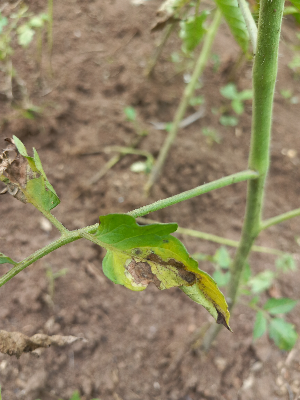

In [4]:
# Print out test image
test_img = '/content/crop-disease-ghana/input/Tomato/Tomato__Early_Blight/images/20230518_134246.jpg'
test_img = cv2.imread(test_img)
#cv2_imshow(test_img)

def display_image(test_img):
    h, w = test_img.shape[0:2]
    neww = 300
    newh = int(neww*(h/w))
    test_img = cv2.resize(test_img, (neww, newh))
    cv2_imshow(test_img)
    cv2.waitKey(0)

display_image(test_img)

In [5]:
# Show files in directory
os.listdir('/content/crop-disease-ghana/input')

['label_map.pbtxt',
 'Pepper',
 'Tomato',
 'catyegory_index.pbtxt',
 'Corn',
 'label_map.txt',
 'dataset_labels.csv',
 'label_map.json']

In [6]:
# Read csv file with data labels
labels_df = pd.read_csv('/content/crop-disease-ghana/input/dataset_labels.csv')
labels_df.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path
0,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2052.653343,695.836619,2210.117161,785.809054,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
1,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1110.682288,901.086237,1228.780152,982.623756,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
2,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1647.746382,912.332791,1791.150930,1002.305226,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
3,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2491.302550,1275.034169,2589.717436,1367.818243,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
4,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3326.423156,1255.352699,3410.778773,1339.701857,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...


In [7]:
# Create new column combining width and height column
labels_df['shape'] = 0
shape_lst = []
for i in range(len(labels_df)):
  shape_lst.append((labels_df['width'][i],labels_df['height'][i]))

labels_df['shape'] = shape_lst
labels_df['shape'].value_counts()

(4032, 3024)    19548
(4080, 1836)    13500
(1920, 1280)    12418
(4080, 3060)     9007
(720, 480)       1473
(4000, 3000)     1123
(6720, 4480)      552
(1920, 2560)      428
(2560, 1920)      210
(2576, 1932)      102
Name: shape, dtype: int64

In [8]:
# Merge similar classes
labels_df.replace(['Pepper Late Blight','Pepper Early Blight'],'Pepper Leaf Blight',inplace = True)
labels_df.replace(['Tomato Late Blight','Tomato Early Blight'],'Tomato Leaf Blight',inplace = True)

In [9]:
# Drop labels with too little data or multiple diseases
labels_df = labels_df[labels_df['disease'] != 'Tomato Mosaic']
labels_df = labels_df[labels_df['disease'] != 'Corn Northern Leaf Blight']
labels_df = labels_df[labels_df['disease'] != 'Pepper Leaf Mosaic']
labels_df['disease'].value_counts()

Corn Cercospora Leaf Spot    9431
Tomato Septoria              9211
Tomato Leaf Blight           7993
Corn Streak                  4591
Tomato Healthy               4066
Pepper Septoria              3222
Pepper Bacterial Spot        2780
Corn Common Rust             2434
Corn Healthy                 2304
Pepper Leaf Curl             2175
Pepper Leaf Blight           1660
Tomato Fusarium              1238
Pepper Healthy               1049
Pepper Cercospora             704
Pepper Fusarium               696
Tomato Leaf Curl              641
Tomato Bacterial Spot         639
Name: disease, dtype: int64

In [10]:
# Fix img path
loc_path = '/content/crop-disease-ghana/'
new_img = []
for txt in labels_df['img_path']:
  n = loc_path + txt.replace('\\','/')
  new_img.append(n)
labels_df['img_path'] = new_img
labels_df['img_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230524_104642.jpg'

In [11]:
# Fix annotation path
loc_path = '/content/crop-disease-ghana/'
new_ann = []
for txt in labels_df['ann_path']:
  a = loc_path + txt.replace('\\','/')
  new_ann.append(a)
labels_df['ann_path'] = new_ann
labels_df['ann_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/annotations/20230524_104642.xml'

In [12]:
# Labels for categories
labels = {}
#np.unique(no_duplicates['disease'])
lab_len = len(np.unique(labels_df['disease']))
for j,i in zip(np.unique(labels_df['disease']),range(1,lab_len + 1)):
  labels[j] = i
print(labels)

{'Corn Cercospora Leaf Spot': 1, 'Corn Common Rust': 2, 'Corn Healthy': 3, 'Corn Streak': 4, 'Pepper Bacterial Spot': 5, 'Pepper Cercospora': 6, 'Pepper Fusarium': 7, 'Pepper Healthy': 8, 'Pepper Leaf Blight': 9, 'Pepper Leaf Curl': 10, 'Pepper Septoria': 11, 'Tomato Bacterial Spot': 12, 'Tomato Fusarium': 13, 'Tomato Healthy': 14, 'Tomato Leaf Blight': 15, 'Tomato Leaf Curl': 16, 'Tomato Septoria': 17}


In [13]:
# Use categorical labels to make new target column
enc_labels = []
for i in labels_df['disease']:
  for k,v in labels.items():
    if i == k :
      enc_labels.append(labels[i])
labels_df['label'] = enc_labels
labels_df.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2052.653343,695.836619,2210.117161,785.809054,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
1,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1110.682288,901.086237,1228.780152,982.623756,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
2,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1647.746382,912.332791,1791.150930,1002.305226,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
3,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2491.302550,1275.034169,2589.717436,1367.818243,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
4,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3326.423156,1255.352699,3410.778773,1339.701857,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1


<Axes: xlabel='crop', ylabel='count'>

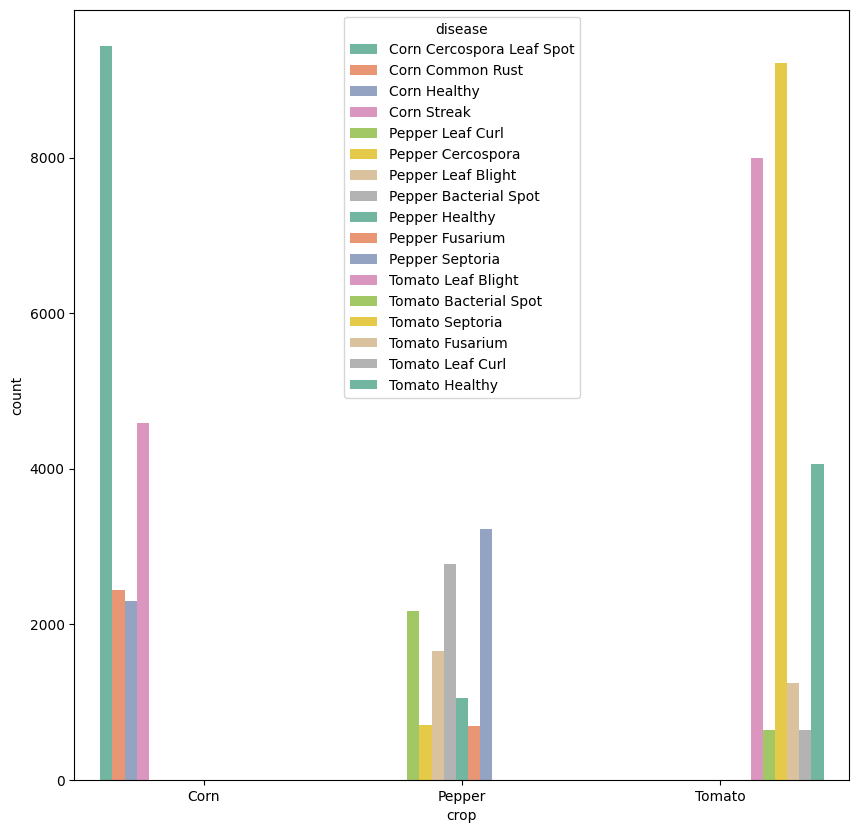

In [14]:
# Crop type and disease distribution
plt.figure(figsize = (10,10))
sns.countplot(x = labels_df['crop'],hue = labels_df['disease'],palette = 'Set2')

In [15]:
# Drop duplicates
no_duplicates = labels_df.drop_duplicates(subset = 'img_path',ignore_index=True)
no_duplicates.reset_index()
no_duplicates.shape

(6919, 14)

<Axes: xlabel='crop', ylabel='count'>

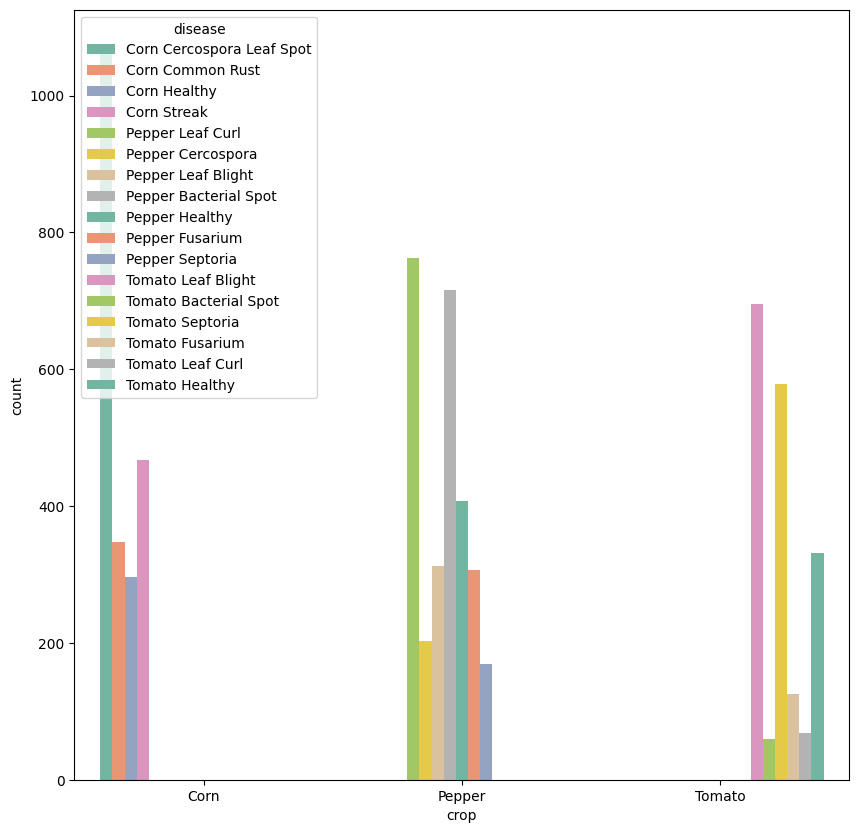

In [16]:
# Crop type and disease distribution
plt.figure(figsize = (10,10))
sns.countplot(x = no_duplicates['crop'],hue = no_duplicates['disease'],palette = 'Set2')

In [17]:
# Disease value counts
no_duplicates['disease'].value_counts()

Corn Cercospora Leaf Spot    1072
Pepper Leaf Curl              763
Pepper Bacterial Spot         716
Tomato Leaf Blight            696
Tomato Septoria               579
Corn Streak                   467
Pepper Healthy                408
Corn Common Rust              348
Tomato Healthy                331
Pepper Leaf Blight            312
Pepper Fusarium               306
Corn Healthy                  296
Pepper Cercospora             203
Pepper Septoria               169
Tomato Fusarium               126
Tomato Leaf Curl               68
Tomato Bacterial Spot          59
Name: disease, dtype: int64

### Looks like there is class imbalance. In order to address this problem, there should be a combination of resampling and data augmentation.

In [18]:
# Modifed from:
# https://medium.com/@a.karazhay/guide-augment-images-and-multiple-bounding-boxes-for-deep-learning-in-4-steps-with-the-notebook-9b263e414dac
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

def image_aug(df,aug_images_path, image_prefix, augmentor,ref_df):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=labels_df.columns)
    grouped = df.groupby('filename')
    for filename,i in zip(df['filename'].unique(),range(len(df))):
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)
    #   read the image
        image = imageio.imread(ref_df['img_path'][i])
    #   get bounding boxes coordinates and write into array
        bb_array = group_df.drop(['filename', 'disease', 'crop', 'width', 'height', 'depth',
                                  'ann_path', 'img_path','label','shape'], axis=1).values
        #print(bb_array, image.shape)
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)

    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()

    #   don't perform any actions with the image if there are no bounding boxes left in it
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass

    #   otherwise continue
        else:
        #   write augmented image to a file
            os.chdir(aug_images_path)
            name = image_prefix+'_'+filename
            cv2.imwrite(name, image_aug)
            #imageio.imwrite(aug_images_path, image_aug,plugin='DICOM')
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            #info_df['filename'] = info_df['filename'].replace(info_df['filename'][i],name)
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+'_'+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])

    # return dataframe with updated images and bounding boxes annotations
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy


In [19]:
# Augmentors to use
aug_flip = iaa.Sequential([
    iaa.Fliplr(1)
])
aug_rotate = iaa.Sequential([
    iaa.Affine(rotate=(-60, 60))
])

aug_blur = iaa.Sequential([
    iaa.GaussianBlur(sigma=(2.0, 3.0))
])

aug_noise = iaa.Sequential([
  iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
])

In [20]:
# Going to augment rare classes the append augmented data to labels_df
tlc_df = labels_df[labels_df['disease']=='Tomato Leaf Curl'].reset_index()
tbs_df = labels_df[labels_df['disease']=='Tomato Bacterial Spot'].reset_index()
pc_df = labels_df[labels_df['disease']=='Pepper Cercospora'].reset_index()
ps_df = labels_df[labels_df['disease']=='Pepper Septoria'].reset_index()
tf_df = labels_df[labels_df['disease']=='Tomato Fusarium'].reset_index()

In [21]:
# Make folders to store augmented images
!mkdir Tomato_Leaf_Curl_Aug
!mkdir Tomato_Bacterial_Spot_Aug
!mkdir Pepper_Cercospora_Aug
!mkdir Pepper_Septoria_Aug
!mkdir Tomato_Fusarium_Aug

In [22]:
# Create augmented data set
def make_aug(df,aug_dir):
  aug_list = [aug_flip,aug_rotate,aug_blur,aug_noise]

  aug_df = image_aug(df[labels_df.columns],
                   aug_dir, 'flip', aug_list[0],df)
  label = ['rotate','blur','noise']
  for a,n in zip(aug_list[1:],label):
    aug_df = aug_df.append(image_aug(df[labels_df.columns],
                   aug_dir, n, a,df))
  # Drop rows with null
  aug_df = aug_df.dropna()
  return aug_df

In [23]:
# Make augmented datasets
tlc_aug = make_aug(tlc_df,'/content/Tomato_Leaf_Curl_Aug').reset_index()
tbs_aug = make_aug(tbs_df,'/content/Tomato_Bacterial_Spot_Aug').reset_index()
pc_aug = make_aug(pc_df,'/content/Pepper_Cercospora_Aug').reset_index()
ps_aug = make_aug(ps_df,'/content/Pepper_Septoria_Aug').reset_index()
tf_aug = make_aug(tf_df,'/content/Tomato_Fusarium_Aug').reset_index()

In [24]:
# Number of unique augmented images
print(len(tlc_aug['filename'].unique()))
print(len(tbs_aug['filename'].unique()))
print(len(pc_aug['filename'].unique()))
print(len(ps_aug['filename'].unique()))
print(len(tf_aug['filename'].unique()))

380
371
893
666
456


In [25]:
print(len(os.listdir('/content/Tomato_Leaf_Curl_Aug')))
print(len(os.listdir('/content/Tomato_Bacterial_Spot_Aug')))
print(len(os.listdir('/content/Pepper_Cercospora_Aug')))
print(len(os.listdir('/content/Pepper_Septoria_Aug')))
print(len(os.listdir('/content/Tomato_Fusarium_Aug')))

380
371
893
666
456


In [26]:
tlc_aug.head()

,index,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,0,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,1533.429932,1586.780884,1840.773926,2167.487305,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16
1,1,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,618.202393,1597.042847,1096.607178,2033.170288,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16
2,2,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,2577.438477,902.496277,2912.614014,1354.034424,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16
3,3,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,1315.911865,1372.759277,1736.795410,1517.977295,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16
4,4,flip_IMG_3011.jpeg,Tomato Leaf Curl,Tomato,4032,3024,3,2185.676270,1207.585449,2512.000732,1416.671509,/content/crop-disease-ghana/input/Tomato/Tomat...,/content/crop-disease-ghana/input/Tomato/Tomat...,"(4032, 3024)",16


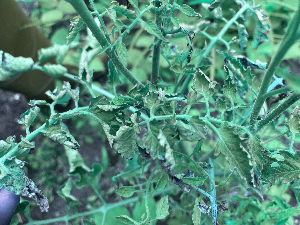

In [27]:
p = '/content/Tomato_Leaf_Curl_Aug/' + tlc_aug['filename'][0]
test_img=cv2.imread(p)
def display_image(test_img):
    h, w = test_img.shape[0:2]
    neww = 300
    newh = int(neww*(h/w))
    test_img = cv2.resize(test_img, (neww, newh))
    cv2_imshow(test_img)
    cv2.waitKey(0)

display_image(test_img)

In [28]:
# Replace image paths
tlc_aug['img_path'] = '/content/Tomato_Leaf_Curl_Aug/' + tlc_aug['filename']
tbs_aug['img_path'] = '/content/Tomato_Bacterial_Spot_Aug/' + tbs_aug['filename']
pc_aug['img_path'] = '/content/Pepper_Cercospora_Aug/' + pc_aug['filename']
ps_aug['img_path'] = '/content/Pepper_Septoria_Aug/' + ps_aug['filename']
tf_aug['img_path'] = '/content/Tomato_Fusarium_Aug/' + tf_aug['filename']

In [29]:
# Drop index column
tlc_aug = tlc_aug.drop(labels = 'index',axis = 1)
tbs_aug = tbs_aug.drop(labels = 'index',axis = 1)
pc_aug = pc_aug.drop(labels = 'index',axis = 1)
ps_aug = ps_aug.drop(labels = 'index',axis = 1)
tf_aug = tf_aug.drop(labels = 'index',axis = 1)

In [30]:
# Append to labels_df
labels_df = labels_df.append(tlc_aug)
labels_df = labels_df.append(tbs_aug)
labels_df = labels_df.append(pc_aug)
labels_df = labels_df.append(ps_aug)
labels_df = labels_df.append(tf_aug)
labels_df = labels_df.reset_index()

In [31]:
labels_df.shape

(70259, 15)

In [32]:
# Drop duplicates
no_duplicates = labels_df.drop_duplicates(subset = 'filename',ignore_index=True)
#no_duplicates.reset_index()
no_duplicates.shape

(9191, 15)

In [33]:
no_duplicates['disease'].value_counts()

Pepper Cercospora            1096
Corn Cercospora Leaf Spot    1021
Pepper Septoria               835
Pepper Leaf Curl              760
Pepper Bacterial Spot         706
Tomato Leaf Blight            632
Tomato Fusarium               570
Corn Streak                   467
Tomato Leaf Curl              447
Tomato Bacterial Spot         412
Tomato Septoria               409
Pepper Healthy                366
Tomato Healthy                331
Pepper Leaf Blight            312
Pepper Fusarium               306
Corn Healthy                  280
Corn Common Rust              241
Name: disease, dtype: int64

In [34]:
# Create final balanced dataset
balanced = pd.DataFrame(columns = labels_df.columns)
for i in no_duplicates['disease'].unique():
  df = no_duplicates[no_duplicates['disease'] == i]
  if len(df)>200:
    samp = df.sample(n = 200,random_state = 24)
    balanced = balanced.append(samp)
  else:
    balanced = balanced.append(df)

In [35]:
balanced['disease'].value_counts()

Corn Cercospora Leaf Spot    200
Pepper Fusarium              200
Tomato Leaf Curl             200
Tomato Fusarium              200
Tomato Septoria              200
Tomato Bacterial Spot        200
Tomato Leaf Blight           200
Pepper Septoria              200
Pepper Healthy               200
Corn Common Rust             200
Pepper Bacterial Spot        200
Pepper Leaf Blight           200
Pepper Cercospora            200
Pepper Leaf Curl             200
Corn Streak                  200
Corn Healthy                 200
Tomato Healthy               200
Name: disease, dtype: int64

In [36]:
# Create final balanced df
balanced_df = pd.DataFrame(columns = balanced.columns)
for i in np.unique(balanced['filename']):
  df = labels_df[labels_df['filename'] == i]
  balanced_df = balanced_df.append(df,ignore_index = True)
#balanced_df = balanced_df.reset_index()
#balanced_df = balanced_df.drop(labels = ['index','level_0'],axis = 1)
balanced_df.head()



,index,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,21667,2010-01-01%2000.06.21.jpg,Pepper Healthy,Pepper,1920,2560,3,938.970994,1550.683230,1672.769337,2274.989648,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",8
1,21668,2010-01-01%2000.06.21.jpg,Pepper Healthy,Pepper,1920,2560,3,281.933702,1781.283644,611.042818,2365.175983,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",8
2,19004,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,1199.818892,1273.706070,1272.400568,1334.632588,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6
3,19005,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,952.734375,1139.371672,1015.887784,1173.418530,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6
4,19006,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,1037.791193,993.439830,1091.313920,1037.018104,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6


In [39]:
# Dropping unecessary columns
balanced_df = balanced_df.drop(labels =['index'],axis = 1)
balanced_df.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,2010-01-01%2000.06.21.jpg,Pepper Healthy,Pepper,1920,2560,3,938.970994,1550.683230,1672.769337,2274.989648,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",8
1,2010-01-01%2000.06.21.jpg,Pepper Healthy,Pepper,1920,2560,3,281.933702,1781.283644,611.042818,2365.175983,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",8
2,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,1199.818892,1273.706070,1272.400568,1334.632588,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6
3,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,952.734375,1139.371672,1015.887784,1173.418530,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6
4,2010-01-01%2000.11.06.jpg,Pepper Cercospora,Pepper,1920,2560,3,1037.791193,993.439830,1091.313920,1037.018104,/content/crop-disease-ghana/input/Pepper/Peppe...,/content/crop-disease-ghana/input/Pepper/Peppe...,"(1920, 2560)",6


In [40]:
df_balanced = pd.DataFrame(columns = labels_df.columns)
for i in np.unique(balanced_df['disease']):
  df = balanced_df[balanced_df['disease'] == i]
  if len(df)>200:
    samp = df.sample(n = 200,random_state = 24)
    df_balanced = df_balanced.append(samp,ignore_index = True)
  else:
    df_balanced = df_balanced.append(df,ignore_index = True)


In [42]:
df_balanced = df_balanced.drop(labels =['index'],axis = 1)
df_balanced.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,20230526_114545.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2089.895178,897.998932,2172.578616,1003.483405,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
1,20230526_103506(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2717.148847,592.949243,2822.641509,672.775330,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
2,20230525_111356(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2941.199173,1275.034169,3076.168160,1407.181183,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
3,20230524_110802.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2857.733711,753.781004,2941.529745,826.064469,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
4,20230526_102705.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2976.603774,1257.216324,3062.138365,1348.446137,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1


#Old code starts here

In [ ]:
# df=labels_df['disease'].value_counts()/15
# sorted_disease_counts = df.sort_index()
# sorted_disease_counts

In [ ]:
#np.unique(labels_df['disease'])

In [ ]:
# # Create balanced dataset
# df_balanced = pd.DataFrame(columns = labels_df.columns)
# indx=0
# for i in np.unique(labels_df['disease']):
#   df = labels_df[labels_df['disease']==i]
#   samp = df.sample(n = int(sorted_disease_counts[indx]))
#   df_balanced = df_balanced.append(samp,ignore_index = True)
#   indx=indx+1

In [43]:
width=224
height=224
depth= 3
epoch_= 25
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
#root_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
INIT_LR = 1e-3


In [184]:
# def augment_image_with_bboxes(image, bounding_boxes):
#     # Create an ImageDataGenerator with specified augmentation parameters
#     aug = ImageDataGenerator(
#         rotation_range=25, width_shift_range=0.1,
#         height_shift_range=0.1, shear_range=0.2,
#         zoom_range=0.2, horizontal_flip=True,
#         fill_mode="nearest"
#     )

#     # Convert the image to a 4D array (batch_size=1)
#     image = image.reshape((1,) + image.shape)

#     # Create a generator for augmented images
#     augmented_images_generator = aug.flow(image, batch_size=1)

#     # Get the augmented image
#     augmented_image = next(augmented_images_generator)[0]

#     # Extract the augmented image array and convert it back to an image
#     augmented_image = img_to_array(augmented_image).astype(np.uint8)

#     # Apply the same transformation to the bounding boxes
#     augmented_bounding_boxes = []

#     #for box in bounding_boxes:
#     x_min, y_min, x_max, y_max = bounding_boxes
#     points = np.array([[x_min, y_min], [x_max, y_max]], dtype=np.float32).reshape((1, 1, 4))
#     transform_params = aug.get_random_transform(img_shape=image.shape[1:])
#     augmented_points = aug.apply_transform(points, transform_params).reshape(4,)
#     augmented_bounding_boxes.append(augmented_points)

#     return augmented_image, augmented_bounding_boxes

# def convert_image_to_array(image_dir, bounding_boxes):
#     try:
#         image = cv2.imread(image_dir)
#         if image is not None:
#             # Resize the image to the default size
#             image = cv2.resize(image, default_image_size)

#             # Augment the image and bounding boxes
#             augmented_image, augmented_bounding_boxes = augment_image_with_bboxes(image, bounding_boxes)

#             return augmented_image, augmented_bounding_boxes
#         else:
#             return np.array([]), []
#     except Exception as e:
#         print(f"Error: {e}")
#         return None, []

In [44]:
def convert_image_to_array(image_dir):
    # aug = ImageDataGenerator(
    # rotation_range=25, width_shift_range=0.1,
    # height_shift_range=0.1, shear_range=0.2,
    # zoom_range=0.2,horizontal_flip=True,
    # fill_mode="nearest")

    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            #image = image.reshape((1,) + image.shape) #New line of code
            #augmented_images=aug.flow(image,batch_size=1) #new line of code
            #augmented_images_array=next(augmented_images)[0] #new line of code
            return img_to_array(image)
            #return augmented_images_array
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [45]:
df_balanced.shape

(3400, 14)

In [46]:
new_xmin = []
new_ymin = []
new_xmax = []
new_ymax = []

for i in range(df_balanced.shape[0]):
  w=df_balanced['width'][i]
  h=df_balanced['height'][i]
  xmin=df_balanced['xmin'][i]
  ymin=df_balanced['ymin'][i]
  xmax=df_balanced['xmax'][i]
  ymax=df_balanced['ymax'][i]
  new_xmin.append(float(xmin) / w)
  new_ymin.append(float(ymin) / h)
  new_xmax.append(float(xmax) / w)
  new_ymax.append(float(ymax) / h)

df_balanced['xmin'] = new_xmin
df_balanced['ymin'] = new_ymin
df_balanced['xmax'] = new_xmax
df_balanced['ymax'] = new_ymax
df_balanced.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape,label
0,20230526_114545.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.512229,0.489106,0.532495,0.546560,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
1,20230526_103506(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.665968,0.322957,0.691824,0.366435,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
2,20230525_111356(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.720882,0.694463,0.753963,0.766439,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
3,20230524_110802.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.700425,0.410556,0.720963,0.449926,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1
4,20230526_102705.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.729560,0.684758,0.750524,0.734448,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)",1


In [47]:
image_list, label_list, bboxes_list, imagePaths_list = [], [], [], []

indx=0
i=0
try:
  for img_dir in df_balanced['img_path']:
  #for i in range(2):
    #img_dir= f"{root_dir}/{plant_folder}/{plant_disease_folder}/{image}"
    if img_dir.endswith(".jpg") == True or img_dir.endswith(".JPG") == True:
      image_list.append(convert_image_to_array(img_dir))
      imagePaths_list.append(df_balanced['img_path'][indx])
      label_list.append(df_balanced['disease'][indx])
      bboxes_list.append((df_balanced['xmin'][indx], df_balanced['ymin'][indx], df_balanced['xmax'][indx], df_balanced['ymax'][indx]))
      indx=indx+1
except Exception as e:
  print(f"Error : {e}")

In [187]:
# image_list, label_list, bboxes_list, imagePaths_list = [], [], [], []
# indx=0
# i=0
# try:
#   for img_dir in df_balanced['img_path']:
#   #for i in range(2):
#     #img_dir= f"{root_dir}/{plant_folder}/{plant_disease_folder}/{image}"
#     if img_dir.endswith(".jpg") == True or img_dir.endswith(".JPG") == True:
#       bndboxes=[]
#       bndboxes=(df_balanced['xmin'][indx], df_balanced['ymin'][indx], df_balanced['xmax'][indx], df_balanced['ymax'][indx])
#       #image_list.append(convert_image_to_array(img_dir))
#       augmented_image, augmented_bounding_boxes = convert_image_to_array(img_dir, bndboxes) # New line of code
#       image_list.append(augmented_image)# New line of code
#       label_list.append(df_balanced['disease'][indx])
#       bboxes_list.append(augmented_bounding_boxes)
#       imagePaths_list.append(df_balanced['img_path'][indx])
#       #bboxes_list.append((df_balanced['xmin'][indx], df_balanced['ymin'][indx], df_balanced['xmax'][indx], df_balanced['ymax'][indx]))

#       indx=indx+1
# except Exception as e:
#   print(f"Error : {e}")

In [48]:
data, labels, bboxes, imagePaths = [], [], [], []
data = np.array(image_list, dtype="float32") / 255.0
labels = np.array(label_list)
bboxes = np.array(bboxes_list, dtype="float32")
imagePaths = np.array(imagePaths_list)

In [49]:
print (data[0], labels[0], bboxes[0], imagePaths[0])

[[[0.23921569 0.73333335 0.50980395]
  [0.35686275 0.8156863  0.60784316]
  [0.33333334 0.79607844 0.59607846]
  ...
  [0.         0.36862746 0.23137255]
  [0.         0.3137255  0.14509805]
  [0.         0.2784314  0.10980392]]

 [[0.1254902  0.5921569  0.36078432]
  [0.12941177 0.5882353  0.35686275]
  [0.25490198 0.75686276 0.5411765 ]
  ...
  [0.         0.30980393 0.11764706]
  [0.         0.27450982 0.10588235]
  [0.         0.26666668 0.09411765]]

 [[0.08627451 0.59607846 0.34901962]
  [0.12156863 0.59607846 0.34901962]
  [0.13725491 0.6        0.36862746]
  ...
  [0.         0.27450982 0.10588235]
  [0.         0.26666668 0.10588235]
  [0.         0.24313726 0.08235294]]

 ...

 [[0.5764706  0.73333335 0.60784316]
  [0.49411765 0.69411767 0.54509807]
  [0.39607844 0.62352943 0.4627451 ]
  ...
  [0.1254902  0.22745098 0.25490198]
  [0.08235294 0.19607843 0.21568628]
  [0.07843138 0.19215687 0.21176471]]

 [[0.49019608 0.69803923 0.5529412 ]
  [0.36078432 0.5921569  0.42745098]


In [50]:
label_binarizer = LabelBinarizer()
if labels is not None:
  binarylabels = label_binarizer.fit_transform(labels)
  pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
  n_classes = len(label_binarizer.classes_)

In [51]:
print(labels.shape)

(2479,)


In [52]:
split = train_test_split(data, binarylabels, bboxes, test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
#(trainPaths, testPaths) = split[6:]

In [53]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [54]:

# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

58889256/58889256 [==============================] - 2s 0us/step


In [55]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(label_binarizer.classes_), activation="softmax", name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
modell = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [56]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"bounding_box": "mean_squared_error",
	"class_label": "categorical_crossentropy"
	#"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"bounding_box": 1.0,
	"class_label": 1.0
	#"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=INIT_LR)
modell.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(modell.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [57]:
# construct a dictionary for our target training outputs
trainTargets = {
	"bounding_box": trainBBoxes,
	"class_label": trainLabels
	#"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"bounding_box": testBBoxes,
	"class_label": testLabels
	#"bounding_box": testBBoxes
}

In [ ]:
#  unique_labels = np.unique(labels)
# # # Create a mapping from class labels to integer indices
#  label_to_index = {label: index for index, label in enumerate(unique_labels)}
#  # Map your original labels to integer indices
#  indices = [label_to_index[label] for label in labels]
#  class_weights = class_weight.compute_class_weight(class_weight= "balanced", classes = np.unique(indices), y= indices)
#  class_weight_dict = dict(zip(np.unique(indices), class_weights))
#  class_weight_dict = {"class_label": dict(enumerate(class_weights))}
# # #class_weight_dict={"class_label": class_weights}
# # class_weight_dict=class_weights
# # class_weights_bbox=None
# # class_weights_label=None
#  class_weight_dict

In [44]:
#class_weights={'bounding_box':[1,1,1,1],'class_label':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]}
#class_weights = {'output1': {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}, 'output2': {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0 ,17: 1.0}}

In [58]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = modell.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BS,
	epochs=25,
	#class_weight=class_weights,
	verbose=1)

[INFO] training model...
Epoch 1/25
62/62 [==============================] - 23s 112ms/step - loss: 3.1016 - bounding_box_loss: 0.1730 - class_label_loss: 2.9286 - bounding_box_accuracy: 0.3686 - class_label_accuracy: 0.1992 - val_loss: 1.9361 - val_bounding_box_loss: 0.0560 - val_class_label_loss: 1.8802 - val_bounding_box_accuracy: 0.4012 - val_class_label_accuracy: 0.3488
Epoch 2/25
62/62 [==============================] - 4s 63ms/step - loss: 2.0672 - bounding_box_loss: 0.0564 - class_label_loss: 2.0108 - bounding_box_accuracy: 0.4902 - class_label_accuracy: 0.2748 - val_loss: 1.7119 - val_bounding_box_loss: 0.0544 - val_class_label_loss: 1.6575 - val_bounding_box_accuracy: 0.5262 - val_class_label_accuracy: 0.4415
Epoch 3/25
62/62 [==============================] - 4s 65ms/step - loss: 1.9477 - bounding_box_loss: 0.0455 - class_label_loss: 1.9022 - bounding_box_accuracy: 0.5663 - class_label_accuracy: 0.2950 - val_loss: 1.6494 - val_bounding_box_loss: 0.0520 - val_class_label_loss

In [ ]:
#class_weights

In [ ]:
# # Manually apply class weights to classification loss
#class_weights = dict(zip(np.unique(indices), class_weights))
#class_weights
# for epoch in range(25):
#     print("[INFO] training model - Epoch: ", epoch)
#     # loop over all batches of the dataset
#     for (images, targets) in zip(trainImages, zip(trainLabels, trainBBoxes)):
#         # separate the bounding box targets from the classification targets
#         targets_class, targets_bbox = targets
#         print(targets_class)
#         print(targets_bbox)

#         # compute the class weights
#         class_weights_classification = class_weights
#         sample_weights_class = np.array([class_weights_classification[np.argmax(target)] for target in targets_class])
#         print(sample_weights_class)
#         # train the network
#         loss = model.train_on_batch(images, {"class_label": targets_class, "bounding_box": targets_bbox}, sample_weight={"class_label": sample_weights_class, "bounding_box": None})

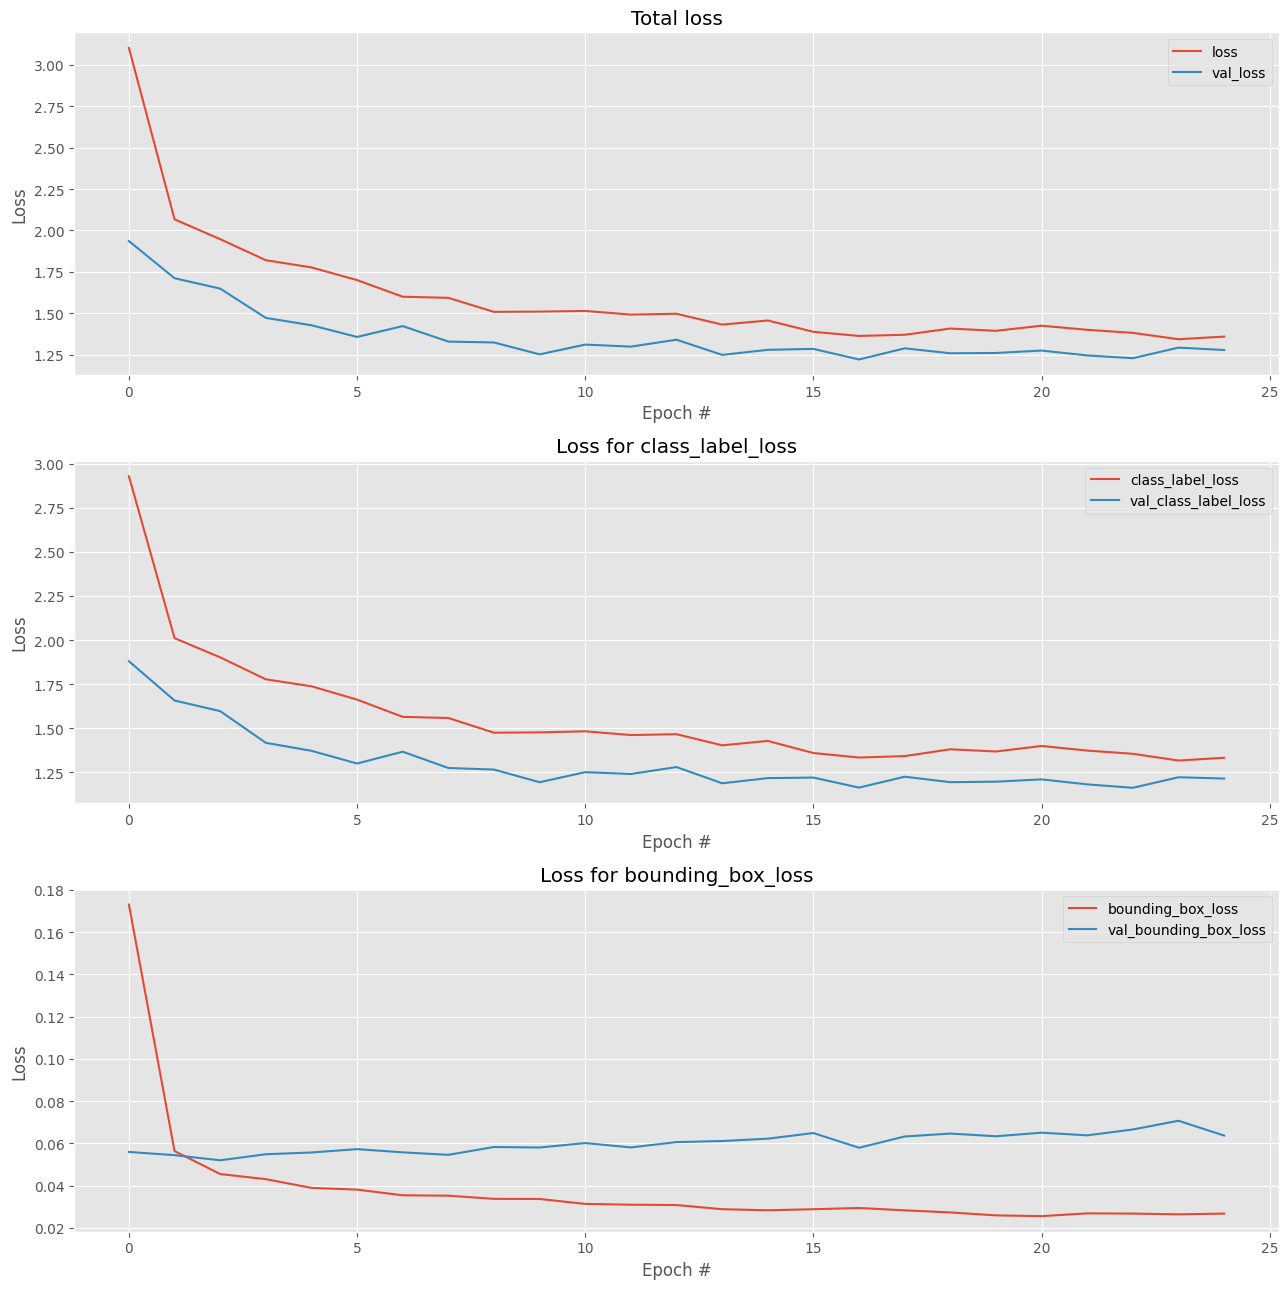

In [59]:
# plot the total loss, label loss, and bounding box loss
epochs=25
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, epochs)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

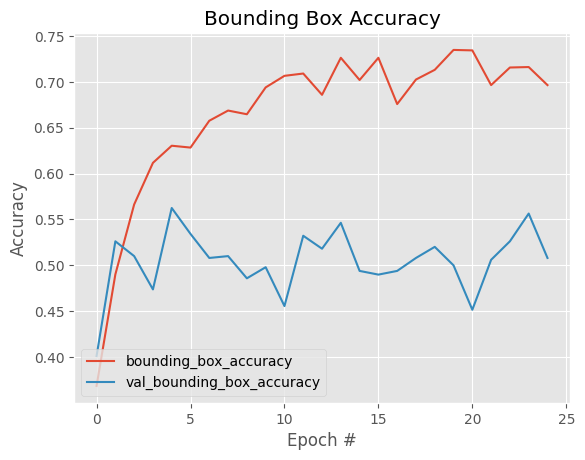

In [60]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
	label="bounding_box_accuracy")
plt.plot(N, H.history["val_bounding_box_accuracy"],
	label="val_bounding_box_accuracy")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


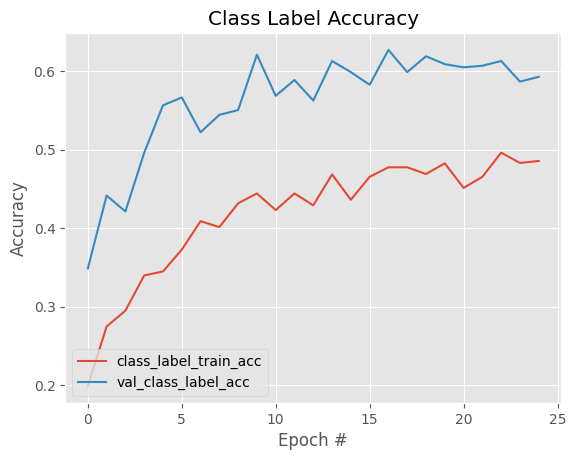

In [61]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


In [62]:
img = '/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230524_104642.jpg'
#img = '/content/crop-disease-ghana/input/Tomato/Tomato__Septoria/images/2N8A0600.JPG'

In [63]:
# loop over the images that we'll be testing using our bounding box
# regression model
#for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]

image = load_img(img, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# predict the bounding box of the object along with the class
# label
(boxPreds, labelPreds) = modell.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
# determine the class label with the largest predicted
# probability
i = np.argmax(labelPreds, axis=1)
label = label_binarizer.classes_[i][0]

1/1 [==============================] - 1s 778ms/step


In [64]:
print(startX, startY, endX, endY)

0.5227035 0.37549558 0.55326325 0.44958708


In [65]:
print(label)

Pepper Bacterial Spot


209 225 221 269


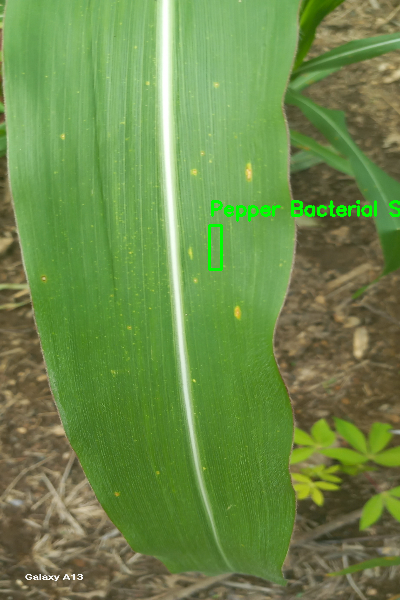

-1

In [66]:
# load the input image (in OpenCV format), resize it such that it
# fits on our screen, and grab its dimensions
from imutils import paths

image = cv2.imread(img)
image = image.copy()
image = cv2.resize(image, (400, 600))
#image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
print(startX, startY, endX, endY)
# draw the predicted bounding box and class label on the image
y = startY - 10 if startY - 10 > 10 else startY + 10
cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

In [67]:
scores = modell.evaluate(testImages, testTargets)
print(f"Test Bounding Box Accuracy: {scores[3]*100}")
print(f"Test Class Label Accuracy: {scores[4]*100}")

16/16 [==============================] - 1s 47ms/step - loss: 1.2788 - bounding_box_loss: 0.0637 - class_label_loss: 1.2150 - bounding_box_accuracy: 0.5081 - class_label_accuracy: 0.5927
Test Bounding Box Accuracy: 50.806450843811035
Test Class Label Accuracy: 59.27419066429138


In [68]:
pred_test=modell.predict(testImages)

16/16 [==============================] - 1s 41ms/step


In [70]:

# Reshape to remove the redundant dimension
converted_coordinates = testBBoxes.reshape((testBBoxes.shape[0], testBBoxes.shape[1]))

print(converted_coordinates)

[[0.45542297 0.66766346 0.5261052  0.70759094]
 [0.4472397  0.45805028 0.5366876  0.5310316 ]
 [0.5735199  0.22531866 0.67679214 0.2906433 ]
 ...
 [0.441478   0.43594    0.4965056  0.5346279 ]
 [0.6053255  0.32573956 0.64561933 0.36646754]
 [0.30718216 0.3675907  0.39954984 0.44447142]]


In [71]:
from sklearn.metrics import mean_squared_error

mse_bbox = mean_squared_error(converted_coordinates, pred_test[0])

In [72]:
print(f"Test Bounding Box Mean Square Error: {mse_bbox*100}")

Test Bounding Box Mean Square Error: 6.371623277664185


In [73]:
threshold = 0.5
binary_predictions = (pred_test[1] > threshold).astype(int)

In [74]:
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

f1_test = f1_score(testLabels, binary_predictions, average='micro')
print(f"Test Classifications F1 score: {f1_test*100}")
accuracy = accuracy_score(testLabels, binary_predictions)
print(f"Test Classifications accracy: {accuracy*100}")
# precision tp / (tp + fp)
precision = precision_score(testLabels, binary_predictions, average='micro')
print(f"Test Classifications precision: {precision*100}")
# recall: tp / (tp + fn)
recall = recall_score(testLabels, binary_predictions, average='micro')
print(f"Test Classifications recall: {recall*100}")

Test Classifications F1 score: 54.423592493297576
Test Classifications accracy: 40.92741935483871
Test Classifications precision: 81.2
Test Classifications recall: 40.92741935483871
